<a href="https://colab.research.google.com/github/g7199/DL-HW-CODES/blob/main/cbow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%cd /content/drive/MyDrive/dl/DLFromScratch2/Chap04-Word2Vec_Improved

/content/drive/MyDrive/dl/DLFromScratch2/Chap04-Word2Vec_Improved


In [5]:
import sys
sys.path.append('..')
from common.np import *
from common.layers import Embedding
from negative_sampling_layer import NegativeSamplingLoss

In [6]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')
        
        # 레이어 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
        
        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs1 = W_in
        self.word_vecs2 = W_out
        
    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)  # average
        loss = self.ns_loss.forward(h, target)
        return loss
    
    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [7]:
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from cbow import CBOW
from skip_gram import SkipGram
from common.util import create_contexts_target, to_cpu, to_gpu
from dataset import ptb

In [14]:
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 1

In [15]:
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

In [16]:
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

| 에폭 1 |  반복 1 / 9295 | 시간 0[s] | 손실 41.59
| 에폭 1 |  반복 2001 / 9295 | 시간 785[s] | 손실 28.08
| 에폭 1 |  반복 4001 / 9295 | 시간 1583[s] | 손실 24.99
| 에폭 1 |  반복 6001 / 9295 | 시간 2381[s] | 손실 24.53
| 에폭 1 |  반복 8001 / 9295 | 시간 3175[s] | 손실 24.30


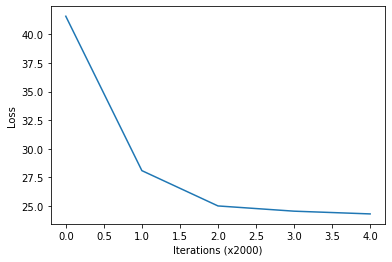

In [17]:
trainer.fit(contexts, target, max_epoch, batch_size, eval_interval=2000)
trainer.plot()